In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import seaborn.apionly as sns

import instrument as ins
import isochrones as iso
import galaxy as gal
import driver
import fit_model

from scipy import stats

import utils
import gpu_utils

import time

In [2]:
%matplotlib inline

In [22]:
def plot_pixcmd(mags, ax=None, colorbar=True):
    pcmd = utils.make_pcmd(mags)
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(pcmd[0], pcmd[1], bins=150, cmap='viridis', norm=mpl.colors.LogNorm())
    if colorbar:
        plt.colorbar(label='Pixel Counts')
    return ax

In [3]:
im_scale = 256
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)
iso_model = iso.Isochrone_Model(filters)

In [4]:
driver_cpu = driver.Driver(iso_model, gpu=False)
driver_gpu = driver.Driver(iso_model, gpu=True)

In [5]:
gal_model_simple = gal.Galaxy_SSP(np.array([-0.2, -2., 2., 9.6]))
gal_model_almost = gal.Galaxy_SSP(np.array([-0.18, -2.02, 2.1, 9.7]))

gal_model_dust = gal.Galaxy_SSP(np.array([-0.2, -0.5, 2., 9.6]))
gal_model_bad = gal.Galaxy_SSP(np.array([-1.9, -5.9, -0.9, 6.1]))
gal_model_lessbad = gal.Galaxy_SSP(np.array([-1.0, -4.0, 1.3, 7.4]))
gal_model_full = gal.Galaxy_Model(np.array([0., -2., 1., 1., 1., 1., 1., 1., 1.]))

In [6]:
pcmd_simple = utils.make_pcmd(driver_gpu.simulate(gal_model_simple, im_scale,
                                                  fixed_seed=True)[1])
xbins = np.arange(-1.5, 4.6, 0.05)
ybins = np.arange(-12, 15.6, 0.05)
bins = np.array([xbins, ybins])

driver_cpu.initialize_data(pcmd_simple, bins)
driver_gpu.initialize_data(pcmd_simple, bins)

In [86]:
im_scale = 2048
_, mags_0, _, ims_0 = driver_gpu.simulate(gal_model_simple, im_scale, psf=True,
                                          multi_psf=True, fixed_seed=True)
_, mags_1, _, ims_1 = driver_gpu.simulate(gal_model_simple, im_scale, psf=True,
                                          multi_psf=True, fixed_seed=True)
_, mags_2, _, ims_2 = driver_gpu.simulate(gal_model_simple, im_scale, psf=True,
                                          multi_psf=False, fixed_seed=True)
_, mags_3, _, ims_3 = driver_gpu.simulate(gal_model_simple, im_scale, psf=True,
                                          multi_psf=True, fixed_seed=False)
_, mags_4, _, ims_4 = driver_gpu.simulate(gal_model_simple, im_scale, psf=True,
                                          multi_psf=False, fixed_seed=False)

In [87]:
im_scale = 2048
_, mags_5, _, ims_5 = driver_gpu.simulate(gal_model_simple, im_scale, psf=False,
                                          fixed_seed=True)
_, mags_6, _, ims_6 = driver_gpu.simulate(gal_model_simple, im_scale, psf=False,
                                          fixed_seed=False)

In [84]:
driver_gpu.initialize_data(utils.make_pcmd(mags_0), bins)

(driver_gpu.loglike(utils.make_pcmd(mags_1)),driver_gpu.loglike(utils.make_pcmd(mags_2)),
 driver_gpu.loglike(utils.make_pcmd(mags_3)), driver_gpu.loglike(utils.make_pcmd(mags_4)))

(-0.0, -6654.3045440360575, -1787.6598550970584, -7689.8037042765154)

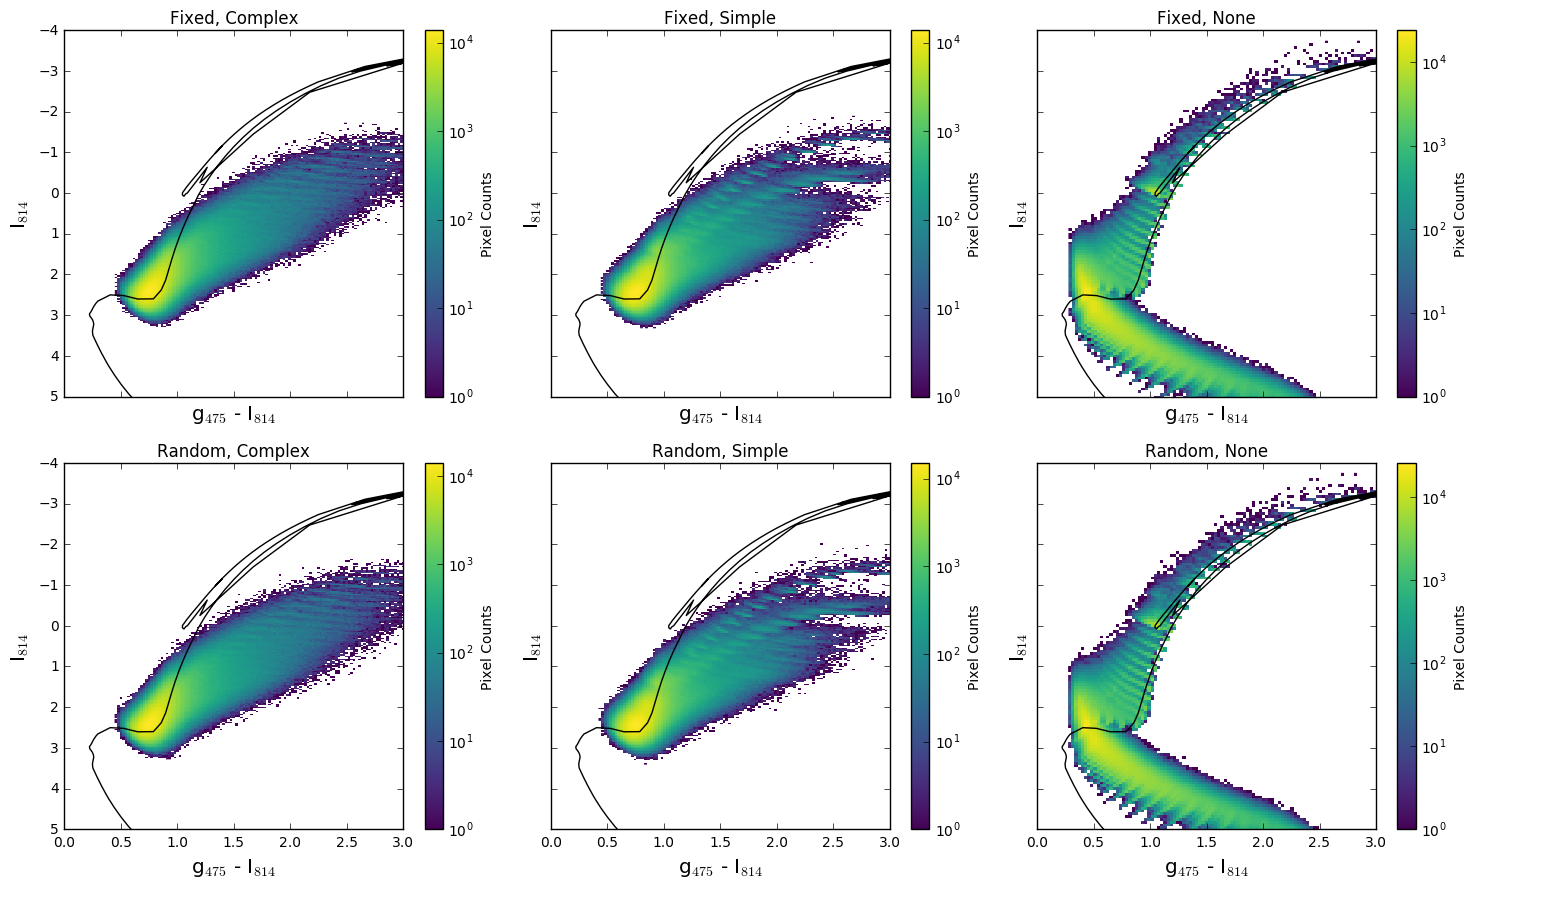

In [88]:
fig, axes = plt.subplots(figsize=(15, 9), ncols=3, nrows=2, sharex=True, sharey=True)
axis = axes[0, 0]
plot_pixcmd(mags_1, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Fixed, Complex')

axis = axes[0,1]
plot_pixcmd(mags_2, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Fixed, Simple')

axis = axes[0,2]
plot_pixcmd(mags_5, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Fixed, None')

axis = axes[1,0]
plot_pixcmd(mags_3, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Random, Complex')

axis = axes[1,1]
plot_pixcmd(mags_4, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Random, Simple')

axis = axes[1,2]
plot_pixcmd(mags_6, ax=axis)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_title('Random, None')

axis.set_ylim([5, -4])
axis.set_xlim([0, 3])
plt.tight_layout()

Stemps 